In [1]:
%matplotlib inline
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd
import csv
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import random
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
from copy import deepcopy
import networkx.algorithms.community.quality as nxq
import community as community_louvain
import random

In [2]:
# load the karate club graph
G = nx.read_edgelist('karate.txt',create_using=nx.Graph(), nodetype = int)

# Leiden Community Detection

In [3]:
def singleton_partition(G):
    partition = []
    for node in G.nodes():
        partition.append({node})
    return partition

In [4]:
print(singleton_partition(G))

[{0}, {9}, {14}, {15}, {16}, {19}, {20}, {21}, {23}, {24}, {27}, {28}, {29}, {30}, {31}, {32}, {33}, {2}, {1}, {3}, {4}, {5}, {6}, {7}, {8}, {10}, {11}, {12}, {13}, {17}, {18}, {22}, {26}, {25}]


In [5]:
def find_community_i(community, i):
    for ind, com in enumerate(community):
        if i in com:
            return ind

In [6]:
def delete_from_com(community, ind, i):
    com = deepcopy(community)
    com[ind].remove(i)
    return com

In [7]:
def add_to_community(community, ind, i):
    com = deepcopy(community)
    com[ind].add(i)
    return com

In [8]:
def get_neighbors_not_in_com(graph, ind_node, partition, node):
    neighbors = graph.neighbors(node)
    return [neigh for neigh in list(neighbors) if neigh not in partition[ind_node]]

In [84]:
def move_nodes_fast(graph, partition):

    Q = list(graph.nodes())
    random.shuffle(Q)
    best_modularity = nxq.modularity(graph, partition, weight='weight')
    best_partition = partition

    while len(Q) > 0:
        new_partition = deepcopy(best_partition)
        next_node = Q.pop(0)
        neigh_node = graph.neighbors(next_node)
        ind_node = find_community_i(new_partition, next_node)
        for neigh in neigh_node:
            partition_copy = deepcopy(new_partition)
            ind_neigh = find_community_i(partition_copy, neigh)
            partition_copy = delete_from_com(partition_copy, ind_node, next_node)
            partition_copy = add_to_community(partition_copy, ind_neigh, next_node)
            partition_copy = [s for s in partition_copy if s != set()] 
            mod = nxq.modularity(graph, partition_copy, weight='weight')
            if mod > best_modularity:
                best_modularity = mod
                best_partition = partition_copy
                new_ind_node = find_community_i(partition_copy, next_node)
                neigh_left = get_neighbors_not_in_com(graph, new_ind_node, partition_copy, next_node)
                neigh_not_in_Q = [neigh for neigh in neigh_left if neigh not in Q]
                Q += neigh_not_in_Q
    return best_partition, best_modularity

In [10]:
# initial partition
partition = [{0, 33, 9, 15, 16, 19, 21, 23, 27, 30, 31}, {1, 18, 20, 22, 12, 13}, {2, 3, 4, 8, 10, 14}, {11, 5}, {17, 6, 7}, {32, 24, 25, 26, 28, 29}]
best_partition, best_modularity = move_nodes_fast(G, partition)

In [11]:
print(best_partition)
print(best_modularity)

[{0, 33, 9, 15, 16, 19, 21, 23, 27, 30, 31}, {1, 12, 13, 18, 20, 22}, {2, 3, 4, 8, 10, 14}, {11, 5}, {17, 6, 7}, {32, 24, 25, 26, 28, 29}]
0.36878057007927134


In [12]:
def weight_subset(graph, nodes):

    total = 0
    degree = graph.degree(nodes, weight='weight')
    for edge in degree:
        data = graph.get_edge_data(edge[0], edge[1])
        if data == None:
            pass
        elif data != {}:
            total += data['weight']
        else:
            total += 1
    return total

In [13]:
def get_connected_nodes(graph, subset, gamma=1):

    nodes = []
    for v in subset:
        deg_v = weight_subset(graph, [v])
        deg_sub = weight_subset(graph, subset)
        subset_wo_v = [s for s in subset if s != v]
        E = weight_subset(graph, subset_wo_v)
        if E >= deg_v * (deg_sub - deg_v):
            nodes.append(v)
    return nodes

In [14]:
def get_connected_communities(graph, subset, partition, gamma=1):

    communities = []
    
    for i, C in enumerate(partition):
        deg_C = weight_subset(graph, C)
        deg_sub = weight_subset(graph, subset)
        subset_wo_C = [commu for commu in subset if commu != C]
        E = weight_subset(graph, subset_wo_C)
        if E >= deg_C * (deg_sub - deg_C):
            communities.append((C, i))
    return communities

In [22]:
def is_in_initial_partition(new_com, initial_partition):
    for com in initial_partition:
        if new_com.issubset(com):
            return True
    return False

In [53]:
def move_node_to_other_com(graph, v, partition, initial_partition, best_modularity, theta, T):

    prob = []
    new_partition = []
    ind_node = find_community_i(partition, v)

    for C, ind_com in T:
        partition_copy = deepcopy(partition)
        partition_copy = delete_from_com(partition_copy, ind_node, v)
        partition_copy = add_to_community(partition_copy, ind_com, v)
        new_com = partition_copy[ind_com]
        partition_copy = [s for s in partition_copy if s != set()] 
        mod = nxq.modularity(graph, partition_copy, weight='weight')

        if mod > best_modularity and is_in_initial_partition(new_com, initial_partition) == True:
            prob.append(np.exp((mod - best_modularity)/theta))
            best_modularity = mod
            best_partition = partition_copy
        else:
            prob.append(0)

        new_partition.append(partition_copy)

    return prob, new_partition

In [54]:
def merge_nodes_subset(graph, partition, initial_partition, subset, theta):

    R = get_connected_nodes(graph, subset)

    best_modularity = nxq.modularity(graph, partition, weight='weight')
    for v in R:
        # print('partititon' + str(partition))
        ind_community = find_community_i(partition, v)
        if len(partition[ind_community]) == 1:
            T = get_connected_communities(graph, subset, partition)
            # print('T' + str(T))
            prob, new_partition = move_node_to_other_com(graph, v, partition, initial_partition, best_modularity, theta, T)
            # print(prob)
            # print(new_partition[3])
            # print(random.choices(new_partition, weights = prob))
            if prob.count(0) == len(prob):
                pass
            else:
                partition = random.choices(new_partition, weights = prob)[0]
    return partition

In [55]:
def refine_partition(graph, partition):

    part_refined = singleton_partition(graph)
    for community in partition:
        part_refined = merge_nodes_subset(graph, part_refined, partition, community, 1)
    return part_refined

In [56]:
partition = [{0, 33, 15, 16, 19, 23, 24, 30}, {9, 21, 31}, {27}, {32, 29}, {1, 2, 12, 18, 20, 22}, {10}, {3, 4, 8, 13, 14}, {11, 5}, {17, 6, 7}, {26}, {25, 28}]
print(refine_partition(G, partition))

[{3, 4, 8, 13, 14}, {0, 33, 15, 16, 19, 23, 24, 30}, {1, 2, 12, 18, 20, 22}, {21}, {27}, {25, 28}, {32, 29}, {9, 31}, {11, 5}, {17, 6, 7}, {10}, {26}]


In [58]:
new_com = {10, 25, 26, 27, 28}
is_in_initial_partition(new_com, partition)

False

In [59]:
def size_link_between_com(com1, com2, graph):

    link = 0
    for node1 in com1:
        for node2 in com2:
            data = graph.get_edge_data(node1, node2)
            if data != None:
                if data != {}:
                    link += data['weight']
                else:
                    link += 1
    return link

In [60]:
def aggregate_graph(graph, partition):

    nodes = graph.nodes()
    edges = graph.edges()

    new_edges = []

    new_graph = nx.Graph()
    new_graph.add_nodes_from([i for i in range(len(partition))])


    for i, com1 in enumerate(partition):
        for j, com2 in enumerate(partition):
            if i >= j:
                if i == j:
                    # self_loops
                    nodes_in_com = [node for node in com1]
                    subGraph = graph.subgraph(nodes_in_com)
                    new_edges.append((i,i, {'weight':subGraph.size(weight='weight')}))
                else:
                    link = size_link_between_com(com1, com2, graph)
                    if link > 0:
                        new_edges.append((i,j, {'weight':link}))

    new_graph.add_edges_from(new_edges)

    return new_graph

In [61]:
def merge_communities(communities, best_communities):

    new_communities = []

    for com in best_communities:
        uni = set()
        for element in com:
            uni = uni.union(communities[element])
        new_communities.append(uni)
    return new_communities  


def find_community_i(community, i):
    for ind, com in enumerate(community):
        if i in com:
            return ind

def merge_communities_first(communities, best_communities):

    new_communities = []
    for com in best_communities:
        uni = set()
        for element in com:
            index = find_community_i(communities, element)
            uni = uni.union(communities[index])
        new_communities.append(uni)
    return new_communities 

In [62]:
# best_communities = [{0, 2, 3, 5}, {1, 4}, {6, 7}]
# communities = [{24, 27, 28, 30}, {0, 33, 9, 15, 16, 19, 21, 23, 31}, {1, 2, 18, 20, 22, 12}, {3, 4, 8, 10, 13, 14}, {11, 5}, {17, 6, 7}, {32, 25, 26, 29}]
best_communities = [{0, 3, 5}, {10, 4, 6}, {8, 7}, {9, 2, 1}]
communities = [{24, 27, 28, 30}, {0, 33, 9, 15, 16, 19, 21, 23, 31}, {1, 3, 4, 8, 10, 12, 13, 14}, {11, 5}, {17, 6, 7}, {18, 2, 20, 22}, {32, 25, 26, 29}]
print(merge_communities_first(communities, best_communities))

[{0, 1, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 21, 23, 31, 33}, {1, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17}, {1, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17}, {0, 1, 2, 3, 4, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 31, 33}]


In [63]:
def is_single_node_partition(partition):
    for com in partition:
        if len(com) > 1:
            return False
    return True

In [68]:
def leiden_algorithm(graph):

    prev_best_community, prev_best_mod = None, None

    First = True
    partition = singleton_partition(graph)

    while 1:

        init_partition = singleton_partition(graph)
        best_partition, best_mod = move_nodes_fast(graph, init_partition)

        part_refined = refine_partition(graph, best_partition)

        graph = aggregate_graph(graph, part_refined)

        if is_single_node_partition(best_partition):
            break

        if First:
            First = False
            partition = merge_communities_first(partition, part_refined)
        else:
            partition = merge_communities(partition, part_refined)

    return partition, best_mod

In [69]:
def load_graph(file_path):
    assert ('txt' in file_path), 'Please choose a graph file of type txt'

    G = nx.read_edgelist(file_path,create_using=nx.Graph(), nodetype = int)
    return G

In [70]:
G = load_graph('karate.txt')
partition, q = leiden_algorithm(G)

In [75]:
def community_to_dict(communities):
    commu = {}
    for i, com in enumerate(communities):
        for node in com:
            commu[node] = i
    return commu

Best modularity found: 0.4298363973688649


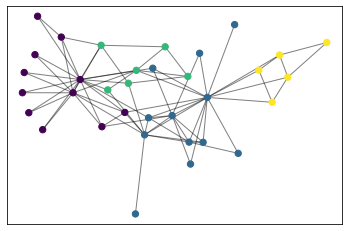

In [85]:
import matplotlib.cm as cm

G = load_graph('karate.txt')
partition, q = leiden_algorithm(G)
partition = community_to_dict(partition)
print(f'Best modularity found: {q}')
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [86]:
import leidenalg
import igraph
g = igraph.Graph.TupleList(G.edges(), directed=False)
part = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)

In [87]:
print(part)

Clustering with 34 elements and 4 clusters
[0] 14, 20, 1, 3, 2, 4, 8, 18, 22, 12, 13, 10
[1] 0, 9, 15, 16, 19, 21, 23, 27, 30, 31, 33
[2] 24, 28, 29, 32, 26, 25
[3] 5, 6, 7, 11, 17


In [88]:
G = load_graph('com-youtube.ungraph.txt')
nodes = list(G.nodes())
G_sub = G.subgraph(nodes[0:100])

Best modularity found: 0.1717397168489658


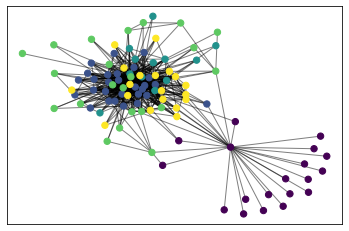

In [89]:
import matplotlib.cm as cm

partition, q = leiden_algorithm(G_sub)
partition = community_to_dict(partition)
print(f'Best modularity found: {q}')
# draw the graph
pos = nx.spring_layout(G_sub)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G_sub, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G_sub, pos, alpha=0.5)
plt.show()